# Lab 1: Welcome to the Travel Marketing Campaign with Generative AI workshop<a class="anchor" id="top"></a>

**Congratulations!** You have just been hired as the marketing manager for an online travel company. Your task is to more effectively promote the flights for an airline through email campaigns using AI. To improve end user engagement (increase click-through-rate) and reduce churn (decrease email unsubscriptions), you will use AI to identify customers with an affinity for specific flights and then use generative AI to to generate marketing content to those users. 

You’ve been asked by the founders to:

- Increase subscriber engagement by tailoring every travel promotions to individual users
- Help improve the enjoyment of trips taken by subscribers through personalized recommendations
- Increase the breadth of content offered to them from the travel catalog
- Reduce the unsubscribe rate of the current non-trageted and non-personalized emails

This workshop is broken up into 3 labs. In this lab you will be training a user segmentation model in [Amazon Personalize](https://aws.amazon.com/personalize/) to more intelligently target users based on their affinity for specific trips. In Lab 2 you will use foundation models in [Amazon Bedrock](https://aws.amazon.com/bedrock/) to generate compelling promotional email text and a banner image. Finally, in Lab 3 you will implement content moderation safeguards to ensure that the generated text and image do not contain inappropriate or unsafe content. The following diagram illustrates the overall architecture with the focus of this lab, Lab 1, highlighted.

![Lab 1 Diagram](images/architecture-lab1.png)


## In this notebook
In this notebook, you will explore the travel company's dataset and prepare it for use with Amazon Personalize to train a user segmentation model. This model will be used to identify the users that have an affinity for the trip that we will be promoting. Once the model is trained, you will run a batch segment job to generate a user segment.

Here are the detailed steps that you will perform in this lab.

1. [How to Use the Notebook](#usenotebook)
1. [Introduction to Amazon Personalize Datasets](#datasets)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Create dataset group](#group_dataset)
1. [Create the Interactions Schema](#interact_schema)
1. [Create the Items Schema](#items_schema)
1. [Create the Users Schema](#users_schema)
1. [Import the Interactions Data](#import_interactions)
1. [Import the Items Metadata](#import_items)
1. [Import the User Metadata](#import_users)
1. [Train user segmentation ML Model](#solutions)
1. [Evaluate solution version metrics](#eval)
1. [Create batch segment job](#batchsegmentjob)
1. [Storing Useful Variables](#vars)

The following diagram illustrates the process graphically.

![User Segmentation Diagram](images/personalize-user-segmentation.png "Personalize User Segmentation")

<div class="alert alert-block alert-warning">
<b>Note:</b> importing data and training models in Amazon Personalize will take more time than we have allocated for this workshop. In order to complete this workshop within the time set, we have pre-created several resources on your behalf. However, the notebooks are designed in such a way that all of the steps are included. If the resources have already been created, the notebook cell will return information about the resources. If the resources have not been created, it will create them for you. 
</div>

## How to use the notebook <a class="anchor" id="usenotebook"></a>

### Executing cells

The code is broken up into cells like the one below. There's a triangular Run button at the top of this page that you can click to execute each cell and move onto the next, or you can press `Shift` + `Enter` while in the cell to execute it and move onto the next one.

As a cell is executing you'll notice a line to the side showcase an `*` while the cell is running or it will update to a number to indicate the last cell that completed executing after it has finished exectuting all the code within a cell.

Simply follow the instructions below and execute the cells to get started with Amazon Personalize.

### Understanding the code

This notebook can be used in two modalities:

1. Train as you go by executing each cell. Some cells may take a long time to finish executing as they wait for resources to be created.
2. Use this notebook with previously created resources. All or the majority of the resources will already be created and cells will just retrieve the information of these existing resources to use them in following steps.

Because of this, you will find that some cells have `try` and `except` blocks. In particular most of them are handling a `ResourceAlreadyExistsException` exception. 

You can look at the code in the `try` block to get a good idea of how you can create a resource and understand how to use the Amazon Personalize SDK. The `except` block will let you know that the resource has been created and record the corresponding ARN, which is the Amazon unique identifier.

This is an example of the `try` block for creating a dataset group, this code will execute without exceptions if the dataset group does not exist and raise an exception if the dataset group does already exist:

```python
try:     
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    
    create_dataset_group_response = personalize.create_dataset_group(
        name = workshop_dataset_group_name
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
    print ('\nCreating the Dataset Group with dataset_group_arn = {}'.format(workshop_dataset_group_arn))
```
and this is the corresponding `except` block that will be exectuted if an exeption is raised because the dataset group already exists. This block saves the ARN for the existig dataset group to use in subsequent cells and lets you know the resource already exists.

```python
except personalize.exceptions.ResourceAlreadyExistsException as e:
    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset group/' + 
        workshop_dataset_group_name 
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(
        workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(
        workshop_dataset_group_arn))
```

Depending on the resource, you may also find that sometimes the code will check from a list of resourses to find if a resource exists and then use `if` and `else` blocks to either use the existing resource or create it.

## Let's build!

Python ships with a broad collection of libraries and we need to import those as well as the ones installed to help us like [boto3](https://aws.amazon.com/sdk-for-python/) (AWS SDK for python) and [Pandas](https://pandas.pydata.org/)/[Numpy](https://numpy.org/) which are core data science tools. Most of these libraries are already installed on the notebook instance but others we need to install or upgrade to the latest version. Let's get that out of the way first.

### Upgrade and install dependencies

<div class="alert alert-block alert-info">
<b>Note:</b> You may receive some warnings/errors about depedencies when you execute the following cell. You can ignore those errors since they are not needed for this lab.
</div>

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall boto3
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall botocore
!{sys.executable} -m pip install --upgrade pandas

  Using cached boto3-1.34.151-py3-none-any.whl.metadata (6.6 kB)
Using cached boto3-1.34.151-py3-none-any.whl (139 kB)
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.151
    Uninstalling boto3-1.34.151:
      Successfully uninstalled boto3-1.34.151
  Using cached botocore-1.34.151-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.151-py3-none-any.whl (12.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.151
    Uninstalling botocore-1.34.151:
      Successfully uninstalled botocore-1.34.151


### Import depedencies

In [2]:
import os.path
import boto3
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from time import sleep
import csv
import yaml
from datetime import datetime
import numpy as np

%matplotlib inline

In [3]:
data_dir = "poc_data"
!mkdir $data_dir

### Initialize clients and inspect environment

Next we'll create the SDK client needed to interact with Amazon Personalize and identify some environment values such as the current AWS account ID and region.

In [4]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')

In [5]:
# Get the account id and region to use later
account_id = boto3.client('sts').get_caller_identity().get('Account')
print("Account ID:", account_id)

with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print("Region:", region)

Account ID: 381491864570
Region: us-east-1


If this is a workshop and the resources were created for you, we will retrieve the variables of the resources created. Otherwise, default values will be used and resources will be created as you step through the rest of this notebook.

In [6]:
# This is the Personalize recipe ARN for this workshop (more details later)
workshop_item_affinity_recipe_arn = "arn:aws:personalize:::recipe/aws-item-affinity"

# Verify that parameter configuation file exists.
parameter_config_file = "params.json"
if os.path.isfile(parameter_config_file):
    # Load parameters
    with open(parameter_config_file, "r") as file:
        parameters = json.load(file)

        workshop_dataset_group_name = parameters['datasetGroup']['serviceConfig']['name']

        interactions_schema_name = parameters['datasets']['interactions']['schema']['serviceConfig']['name']
        interactions_dataset_name = parameters['datasets']['interactions']['dataset']['serviceConfig']['name']

        items_schema_name = parameters['datasets']['items']['schema']['serviceConfig']['name']
        items_dataset_name = parameters['datasets']['items']['dataset']['serviceConfig']['name']

        users_schema_name = parameters['datasets']['users']['schema']['serviceConfig']['name']
        users_dataset_name = parameters['datasets']['users']['dataset']['serviceConfig']['name']

        # The following job names are the prefixes of the job names that can be created
        interactions_import_job_name = 'dataset_import_interaction'
        items_import_job_name = 'dataset_import_item'
        users_import_job_name = 'dataset_import_user'

        for solution in parameters['solutions']:
            # This is currently configured assuming only one solution of this type, if there are multiple
            # solutions of the same type further configuration is needed.
            if solution['serviceConfig']['recipeArn'] == workshop_item_affinity_recipe_arn:
                workshop_item_affinity_solution_name = solution['serviceConfig']['name']

        print(f"Parameters loaded from {parameter_config_file}")
else:
    print("Parameters file not found on local volume; using default values for Personalize resources")
    workshop_dataset_group_name = "personalize-poc-travel"

    interactions_schema_name = "workshop_travel_interactions_schema"
    interactions_dataset_name = "workshop_travel_interactions"

    items_schema_name = "workshop_travel_items_schema"
    items_dataset_name = "workshop_travel_items"

    users_schema_name = "workshop_travel_users_schema"
    users_dataset_name = "workshop_travel_users"

    # The following job names are the prefixes of the job names that can be created
    interactions_import_job_name = "dataset_import_interaction"
    items_import_job_name = "dataset_import_item"
    users_import_job_name = "dataset_import_user"

    workshop_item_affinity_solution_name = "workshop_item_affinity_travel"

# If dataset reference file exists locally, use it. Otherwise, use defaults.
dataset_config_file = "data_files.json"
if os.path.isfile(dataset_config_file):
    with open(dataset_config_file, "r") as file:
        dataset_files = json.load(file)

        interactions_file_path = dataset_files["interactionsFilePath"]
        interactions_file_name = "travel_interactions.csv"

        users_file_path = dataset_files["usersFilePath"]
        users_file_name = 'travel_users.csv'

        items_file_path = dataset_files["itemsFilePath"]
        items_file_name = 'travel_items.csv'

        print(f"Dataset files loaded from {dataset_config_file}")
else:
    print("Dataset reference file not found on local volume; using default values for dataset locations")

    interactions_file_path = "https://d2peeor3oplhc6.cloudfront.net/personalize-immersionday-travel/travel_interactions.csv"
    interactions_file_name = "travel_interactions.csv"

    users_file_path = "https://d2peeor3oplhc6.cloudfront.net/personalize-immersionday-travel/travel_users.csv"
    users_file_name = 'travel_users.csv'

    items_file_path = "https://d2peeor3oplhc6.cloudfront.net/personalize-immersionday-travel/travel_items.csv"
    items_file_name = 'travel_items.csv'

Parameters loaded from params.json
Dataset files loaded from data_files.json


## Introduction to Amazon Personalize datasets <a class="anchor" id="datasets"></a>
[Back to top](#top)

[Amazon Personalize](https://aws.amazon.com/personalize/) is a fully managed machine learning (ML) service that uses your data to train ML models that can be used to generate item recommendations for your users. It can also generate user segments based on users’ affinity for certain items or item metadata.

Regardless of the use case, the algorithms all share a base of learning on user-item-interaction data which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

Generally speaking your data will not arrive in a perfect form for Personalize, and will take some modification to be structured correctly. Since the data provided with this workshop already has the datasets prepared, this step is done for you.

### Interactions data

The interaction dataset consists of information about the interactions the users of the fictional app will have with the content. For this workshop, the interactions represent past trips that users have taken or trips they have shown interest in in the travel application. This data usually comes from order processing systems, analytics tools, or a customer data platform (CDP). The best interaction data for use for Amazon Personalize would include the sequential order of user behavior, what content was clicked on/purchased and the order it was interacted with. To simulate our interaction data, we will be using a synthetic interactions dataset. 

### Items data

The item data consists of information about the content that is being interacted with, this typically comes from a content management system (CMS). For the purpose of this workshop our items are trips that are available to purchase in the travel application. To simulate our items data we will be using a synthetic item dataset.

### User data

The user data is what information you have about your users, it usually comes from a customer relationship management (CRM) or subscriber management system. We will be generating a small synthetic dataset to simulate this component of the workshop. This dataset is not manatory, but providing good user metadata will ensure the best results in your trained models.

In this notebook we will be inspecting the datasets to become familiar with their contents. Then we will import the datasets into Amazon Personalize so that it can be used to train recommendation models.

### Open and explore the simulated travel interactions dataset

Lets copy over our dataset.

In [9]:
interaction_data = pd.read_csv(interactions_file_path)
interaction_data

,ITEM_ID,USER_ID,TIMESTAMP,CABIN_TYPE,EVENT_VALUE,EVENT_TYPE
0,3eca2a68-a504-40f1-847a-8571851f2303,d36108fc-1f35-4441-b6e0-a594659c7bcd,1194566400,Economy,9.0,RATING
1,19d7ad49-9484-4a73-8657-08f66402b32e,0968e0a2-e3e2-49f9-a4ef-a8be7fbdc042,1199750400,Economy,5.0,RATING
2,19d7ad49-9484-4a73-8657-08f66402b32e,d4a2f6ce-e9d5-41b1-85e8-be9cee895161,1208822400,Economy,5.0,RATING
3,19d7ad49-9484-4a73-8657-08f66402b32e,627bd2b5-0a4d-4a70-8770-89fd9f9f7d57,1211673600,Economy,5.0,RATING
4,baaf7b5c-9476-4747-bcdd-72c376e5cfe5,d1594121-6a07-4cde-b504-053064adf271,1213574400,Economy,4.0,RATING
...,...,...,...,...,...,...
34847,9d781e11-03c1-43d9-9ee5-0410e807d018,9a23dbc9-b9cc-4472-bb8a-22b9a23e76a3,1438473600,Economy,1.0,RATING
34848,98cfc892-0015-45fc-9c20-7f7caf783c6c,6c429366-69cb-4645-8b0c-16ad6601dbe3,1438473600,First Class,10.0,RATING
34849,a3f4c942-c207-4b4f-b8c1-d1bbcebdcc34,c074f680-1a5f-4917-8282-4400b779efc8,1438473600,Economy,9.0,RATING
34850,8fc15403-d0ae-4228-82bd-03c28487763f,a5c63044-9863-4c20-9dbe-810fc8531110,1438473600,Economy,9.0,RATING


Take note of a few aspects of the CSV data:

- An `ITEM_ID` column of the item interacted with
- A `USER_ID` column of the user who interacted
- A `TIMESTAMP` of when the interaction happened (represented as a Unix timestamp)
- A custom field called `CABIN_TYPE` that represents the type of flight ticket purchased by the user
- An `EVENT_VALUE` representing the user's rating of the flight on a 10 point scale
- An `EVENT_TYPE` column which can be used to train different Personalize campaigns and also to filter on recommendations; in this case we're only working with flight ratings by users

To use Amazon Personalize, you need to private timestamp values in Unix Epoch format.

Lets validate that the timestamp is actually in a Unix Epoch format by converting it into a more easily understood time/date format

In [9]:
arb_time_stamp = interaction_data.iloc[50]['TIMESTAMP']
print('timestamp')
print(arb_time_stamp)
print()
print('Date & Time')
print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

timestamp
1245542400

Date & Time
2009-06-21 00:00:00


The formatted timestamp looks reasonable given our data so we're good to move on.

We will do some general summarization and inspection of the data to ensure that it will be helpful for Amazon Personalize. The following cell will tell us if any columns have null value(s).

In [10]:
interaction_data.isnull().any()

ITEM_ID        False
USER_ID        False
TIMESTAMP      False
CABIN_TYPE     False
EVENT_VALUE    False
EVENT_TYPE     False
dtype: bool

In [11]:
interaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34852 entries, 0 to 34851
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_ID      34852 non-null  object 
 1   USER_ID      34852 non-null  object 
 2   TIMESTAMP    34852 non-null  int64  
 3   CABIN_TYPE   34852 non-null  object 
 4   EVENT_VALUE  34852 non-null  float64
 5   EVENT_TYPE   34852 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.6+ MB


In [12]:
# save to local storage
interaction_data.to_csv(data_dir+"/"+interactions_file_name, index=False, float_format='%.0f')

### Explore the Users dataset
[Back to top](#top)

Next let's copy over and inspect the users dataset.

In [14]:
user_data = pd.read_csv(users_file_path)
user_data

,USER_ID,MEMBER_TIER
0,c3103c9c-5c7b-4e0e-a8fd-788e3fb5b31d,Member
1,330b7ba7-d0ff-4c09-a001-836a1cb37ed5,Gold
2,53d0e8cb-d09a-4b6d-99ce-0e641f3b539b,Member
3,664dc976-19a9-4721-9df3-861b42ae0d99,Gold
4,7c4780ae-1db3-4bd6-a250-37b761350ff4,Member
...,...,...
24495,b89fbcb6-2d6d-42f5-9073-43436e4e4ff6,Member
24496,8b452698-9c20-4a6c-90a4-6cf0178d0997,Member
24497,870774bc-4ad2-42d9-a9c7-ba5de6585542,Member
24498,19e7d2e4-2310-41c9-9a38-280ebd59b9b8,Member


Besides the required `USER_ID` column, we have a single custom field named `MEMBER_TIER`, which identifies the membership tier of each user.

Let's take a closer look at the distribution of users across the tiers.

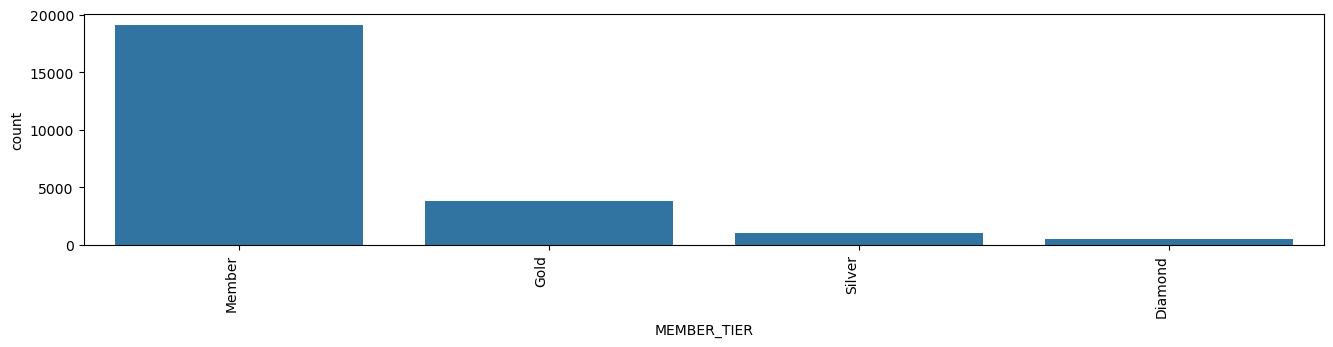

In [15]:
class_attributes = user_data.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
chart = sns.countplot(data = class_attributes, x = 'MEMBER_TIER')
plt.xticks(rotation=90, horizontalalignment='right')
plt.show()

In [16]:
# save to local storage
user_data.to_csv(data_dir+"/"+users_file_name, index=False, float_format='%.0f')

### Explore the Items dataset

Finally, let us look at the items dataset which includes metadata about the flights rated by our users.

In [17]:
item_data = pd.read_csv(items_file_path)
item_data

,ITEM_ID,DST_CITY,SRC_CITY,AIRLINE,DURATION_DAYS,MONTH,NUMBER_OF_SEARCH_BY_USER,PROMOTION,DYNAMIC_PRICE,DISCOUNT_FOR_MEMBER,EXPIRED
0,7beeff60-a8ce-458e-8214-2ab69d75e27a,Hong Kong,Manila,LeopardSpot Airlines,16,April,18444,No,3287,0.00,No
1,b212e95e-9987-4118-8e4d-6744c36f3145,London,Bangkok,HawkGlide Express,17,October,3812,No,9493,0.00,No
2,a9343479-8a8c-4ee1-89fc-38ce032601e9,Beijing,Kuala Lumpur,KoalaHug Express,8,November,16503,Yes,2713,0.25,No
3,71674fa1-79e2-4011-b398-950c82d0e7de,London,Jakarta,ButterflyWing Express,10,June,12086,No,9118,0.00,No
4,077caae0-c79d-44e1-9e43-965b9c9b1e95,Shanghai,Singapore,PeacockPlume Airways,3,October,14729,No,4775,0.00,No
...,...,...,...,...,...,...,...,...,...,...,...
345,21f535f9-40d1-455a-9026-06860ae41fb6,Hong Kong,Bangkok,GiraffeNeck Airways,6,August,3645,Yes,3526,0.40,No
346,e77e1965-f2b1-4224-92b6-e76d58382a20,Tokyo,Bangkok,SlothNap Airlines,8,February,13403,No,8925,0.00,No
347,8993b54e-f409-4ee8-806e-33d3db745f4d,New York,Ho Nai,PolarBearPaw Airways,19,March,3183,Yes,1642,0.20,No
348,8655a4a1-2c34-4328-8fe0-d5c2133003a0,Guangzhou,Bangkok,GazelleGraze Flights,19,June,8878,Yes,5966,0.50,No


Take note of a few aspects of the CSV data:

- An `ITEM_ID` column that represents the item; a flight or trip in our case
- A custom field called `DST_CITY` that represents the destination city of the trip
- A custom field called `SRC_CITY` that represents the source city of the trip
- A custom field called `AIRLINE` that represents the ficticious airline for of the trip
- A custom field called `DISCOUNT_FOR_MEMBER` that represents the discount percentage that members of our travel company receive for the flight
- A custom field called `EXPIRED` that indicates whether the flight/trip is still available or not

Besides training on these fields, we will also use them to lookup flights to promote when we build our marketing campaign in the next notebook.

In [18]:
# save to local storage
item_data.to_csv(data_dir+"/"+items_file_name, index=False, float_format='%.0f')

# Creating Amazon Personalize resources and importing data <a class="anchor" id="import"></a>

## Configure an S3 bucket and IAM  role <a class="anchor" id="bucket_role"></a>
[Back to top](#top)

So far, we have downloaded, inspected, and saved the data onto the Amazon EBS instance attached to our SageMaker notebook instance. Before we can upload this data to Amazon Personalize, we need to stage it in an S3 bucket.

By default, the Amazon Personalize service does not have permission to acccess the data we upload into an S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume. Let's set all of that up.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalize-poc-publishing` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell. Note if you have already created a bucket as part of the cloud formation automation then the cell below will return information on that previously created bucket.

In [19]:
try:
    personalizes3bucket = ssm.get_parameter(Name='/cloudformation/personalize-s3-bucket', WithDecryption=False)
    bucket_name = personalizes3bucket['Parameter']['Value']
    print('Bucket created as part of cloud formation template found')
    print('bucket_name:', bucket_name)
    bucket_found=True
except:
    
    account_id = boto3.client('sts').get_caller_identity().get('Account')
    bucket_name = account_id + "-" + region + "-" + "personalize-poc-travel"

    #getting existing buckets in the account
    response = s3.list_buckets()

    if bucket_name in [x['Name'] for x in response['Buckets']]:
        print("The bucket already exists.")
    else:
        if region == "us-east-1":
            bucket_responese = s3.create_bucket(Bucket=bucket_name)
        else:
            bucket_responese = s3.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
                )
    print('bucket_name:', bucket_name)

The bucket already exists.
bucket_name: 381491864570-us-east-1-personalize-poc-travel


Amazon Personalize needs to be able to read the contents of your S3 bucket. So add a bucket policy which allows that.

In [20]:
if bucket_found:
    bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']
    print("Policy for bucket created as part of cloud formation template:")
    print(json.loads(bucket_current_policy))
else:
    policy = {
        "Version": "2012-10-17",
        "Id": "PersonalizeS3BucketAccessPolicy",
        "Statement": [
            {
                "Sid": "PersonalizeS3BucketAccessPolicy",
                "Effect": "Allow",
                "Principal": {
                    "Service": "personalize.amazonaws.com"
                },
                "Action": [
                    "s3:GetObject",
                    "s3:ListBucket",
                    "s3:PutObject"
                ],
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ]
            }
        ]
    }

    bucket_current_policy = None

    try:
        bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']

    except s3.exceptions.from_code('NoSuchBucketPolicy') as e:    
        print("There is no current Bucket Policy for bucket " + bucket_name)

    except Exception as e: 
        raise(e)

    if (bucket_current_policy and policy == json.loads(bucket_current_policy)):
        print ("The policy is already associated with the S3 Bucket.")
    else:
        print ("Adding the policy to the bucket.")
        print(s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy)))

The policy is already associated with the S3 Bucket.


### Create an IAM role

Amazon Personalize needs the ability to assume roles in AWS in order to have the permissions to execute certain tasks. Let's create an IAM role and attach the required policies to it. The code below attaches very permissive policies; please use more restrictive policies for any production application.

In [21]:
if bucket_found:
    print("Cloud formation template used - skipping creation of IAM role and needed policies for Personalize as they were already created as part of the automation script")
    role_arn_info = ssm.get_parameter(Name='/cloudformation/personalize-iam-role-arn', WithDecryption=False)
    role_arn = role_arn_info['Parameter']['Value']
    role_name = role_arn.split('/')[1]
else:
    iam = boto3.client("iam")

    role_name = account_id+"-PersonalizeS3-Immersion-Day"
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                "Service": "personalize.amazonaws.com"
              },
                "Action": "sts:AssumeRole"
            }
        ]
    }

    # Create policy

    s3_access_policy_document = {
        "Version": "2012-10-17",
        "Statement": {
                "Sid" : "myStatement" ,
                "Effect": "Allow",
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ],
                "Action": "s3:*"
            }
    }

    try: 

        policy_response = iam.create_policy(
            PolicyName='restrictedS3Access',
            PolicyDocument=json.dumps(s3_access_policy_document),
            Description='Restricts access to only workshop S3 bucket'
        )

        s3_access_policy_arn = policy_response['Policy']['Arn']

        print ("s3_access_policy_arn:{}".format(s3_access_policy_arn))
    except:
        s3_access_policy_arn = 'arn:aws:iam::{}:policy/restrictedS3Access'.format(account_id)
        print ('The policy {} already exists.'.format(s3_access_policy_arn))
        print ('Using the existing policy')


    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document),
        );
        role_arn = create_role_response["Role"]["Arn"]

        print ("10s pause to allow role to be fully consistent.")
        time.sleep(10)

    except iam.exceptions.EntityAlreadyExistsException as e:
        print('Warning: role already exists:', e)
        role_arn = iam.get_role(
            RoleName = role_name
        )["Role"]["Arn"];

    print('IAM Role: {}\n'.format(role_arn))

    # Attach the policy if it is not previously attached:
    if (s3_access_policy_arn in [ x['PolicyArn'] for x in iam.list_attached_role_policies( RoleName = role_name)['AttachedPolicies']]):
        print ('The policy {} is already attached to this role.'.format(s3_access_policy_arn))
    else:
        print ("Attaching the role_policy: {}".format(s3_access_policy_arn))
        attach_response = iam.attach_role_policy(
            RoleName = role_name,
            PolicyArn = s3_access_policy_arn
        );
        print ("30s pause to allow role to be fully consistent.")
        time.sleep(30)
        print('Done.')

IAM Role: arn:aws:iam::381491864570:role/381491864570-PersonalizeS3-Immersion-Day

Attaching the role_policy
30s pause to allow role to be fully consistent.
Done.


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV files of our 3 datasets (Item, Interaction and User).

In [22]:
interactions_file_path = data_dir + "/" + interactions_file_name

try:
    s3.get_object(
        Bucket=bucket_name,
        Key=interactions_file_path,
    )
    print("{} already exists in the bucket {}".format(interactions_file_path, bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_file_name).upload_file(interactions_file_path)
    print("File {} uploaded to bucket {}".format(interactions_file_name, bucket_name))

items_file_path = data_dir + "/" + items_file_name

try:
    s3.get_object(
        Bucket=bucket_name,
        Key=items_file_name,
    )
    print("{} already exists in the bucket {}".format(items_file_path, bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object(items_file_name).upload_file(items_file_path)
    print("File {} uploaded to bucket {}".format(items_file_name, bucket_name))

users_file_path = data_dir + "/" + users_file_name

try:
    s3.get_object(
        Bucket=bucket_name,
        Key=users_file_name,
    )
    print("{} already exists in the bucket {}".format(users_file_path, bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object(users_file_name).upload_file(users_file_path)
    print("File {} uploaded to bucket {}".format(users_file_name, bucket_name))

File travel_interactions.csv uploaded to bucket 381491864570-us-east-1-personalize-poc-travel
File travel_items.csv uploaded to bucket 381491864570-us-east-1-personalize-poc-travel
File travel_users.csv uploaded to bucket 381491864570-us-east-1-personalize-poc-travel


## Create Amazon Personalize dataset group <a class="anchor" id="group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can contain the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

We need to create the dataset group that will contain our three datasets.

Your dataset group can be one of the following types:

* A Domain dataset group, where you create preconfigured resources for different business domains and use cases, such as getting recommendations for similar videos (VIDEO_ON_DEMAND domain) or best selling items (ECOMMERCE domain). You choose your business domain, import your data, and create recommenders. You use recommenders in your application to get recommendations. Use a [Domain dataset group](https://docs.aws.amazon.com/personalize/latest/dg/domain-dataset-groups.html) if you have a video on demand or e-commerce application and want Amazon Personalize to find the best configurations for your use cases. If you start with a Domain dataset group, you can also add custom resources such as solutions with solution versions trained with recipes for custom use cases.


* A [Custom dataset group](https://docs.aws.amazon.com/personalize/latest/dg/custom-dataset-groups.html), where you create configurable resources for custom use cases and batch recommendation workflows. You choose a recipe, train a solution version (model), and deploy the solution version with a campaign. You use a campaign in your application to get recommendations. Use a Custom dataset group if you don't have a video on demand or e-commerce application or want to configure and manage only custom resources, or want to get recommendations in a batch workflow. If you start with a Custom dataset group, you can't associate it with a domain later. Instead, create a new Domain dataset group.

You can create and manage Domain dataset groups and Custom dataset groups with the AWS console, the AWS Command Line Interface (AWS CLI), or programmatically with the AWS SDKs.

<div class="alert alert-block alert-warning">
<b>Note:</b> If you are running this as part of an AWS workshop, the resources have been created ahead of time, this is to eliminate the time spent waiting for the data to import, models to train, etc. In these notebooks we will check to see if the resources exist and use them. Therefore, you may see “Resource X Already exists” messages. If you run these notebooks in your own account, it will create these resources as needed, which will add approximatedly 90 minutes to this workshop.
</div>

#### Create Dataset Group

The following cell will create a new dataset group with the name from the workshop parameter file loaded earlier. Since we're working on a use-case for a travel company, we will create a custom dataset group (i.e., without specifying a domain).

In [23]:
try:
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    create_dataset_group_response = personalize.create_dataset_group(
        name = workshop_dataset_group_name
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
    print ('\nCreating the Dataset Group with dataset_group_arn = {}'.format(workshop_dataset_group_arn))

except personalize.exceptions.ResourceAlreadyExistsException as e:
    # if the dataset group already exists, get the unique identifier workshop_dataset_group_arn
    # from the existing resource

    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset-group/'+workshop_dataset_group_name
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(workshop_dataset_group_arn))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:381491864570:dataset-group/personalize-poc-travel",
  "ResponseMetadata": {
    "RequestId": "90a24237-165f-4f0d-9e4d-c8fde5835fd3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Thu, 01 Aug 2024 15:27:12 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "101",
      "connection": "keep-alive",
      "x-amzn-requestid": "90a24237-165f-4f0d-9e4d-c8fde5835fd3",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}

Creating the Dataset Group with dataset_group_arn = arn:aws:personalize:us-east-1:381491864570:dataset-group/personalize-poc-travel


#### Wait for Dataset Group to have ACTIVE status

Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every 15 seconds, up to a maximum of 3 hours.

In [22]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = workshop_dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break

    time.sleep(15)

DatasetGroup: ACTIVE


Now that you have a dataset group, you can create a dataset for the interaction data.

## Create the Interactions schema <a class="anchor" id="interact_schema"></a>
[Back to top](#top)

Now that we've loaded and prepared our three dataset files and uploaded them to an S3 bucket, we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations. Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training and filtering. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format. 

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

Here, you will create a schema for interactions data, which requires the `USER_ID`, `ITEM_ID`, and `TIMESTAMP` fields. We will also be specifying the reserved columns `EVENT_TYPE` and `EVENT_VALUE` as described earlier and finally a custom field for the `CABIN_TYPE` for the trip. These must be defined in the same order in the schema as they appear in the dataset.

Custom fields can be categorical, numeric, or boolean. Categorical fields are those where one or more string-based values can be specified and are indicated in the schema with `"categorical": true` as shown below for `CABIN_TYPE`.

In [23]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name":"CABIN_TYPE",
            "type": "string",
            "categorical": True
        },
        {
          "name": "EVENT_TYPE",
          "type": "string"
        },
        {
          "name": "EVENT_VALUE",
          "type": "float"
        }
    ],
    "version": "1.0"
}

try:
    # Try to create the interactions dataset schema, this block with exectute fully
    # if the interactions dataset schema does not exist yet
    create_schema_response = personalize.create_schema(
        name = interactions_schema_name,
        schema = json.dumps(interactions_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    workshop_interactions_schema_arn = create_schema_response['schemaArn']
    print ('\nCreating the Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset schema already exists, get the unique identifier workshop_interactions_schema_arn
    # from the existing resource

    workshop_interactions_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+interactions_schema_name
    print('The schema {} already exists.'.format(workshop_interactions_schema_arn))
    print ('\nWe will be using the existing Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))


The schema arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_interactions_schema already exists.

We will be using the existing Interactions Schema with workshop_interactions_schema_arn = arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_interactions_schema


### Create the interactions dataset

With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a schema of what the data looks like. 

In [24]:
try:
    # Try to create the interactions dataset, this block with exectute fully
    # if the interactions dataset does not exist yet

    dataset_type = 'INTERACTIONS'
    create_dataset_response = personalize.create_dataset(
        name = interactions_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_interactions_schema_arn
    )

    workshop_interactions_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
    print ('\nCreating the Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset already exists, get the unique identifier workshop_interactions_dataset_arn
    # from the existing resource
    workshop_interactions_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/INTERACTIONS'
    print('The Interactions Dataset {} already exists.'.format(workshop_interactions_dataset_arn))
    print ('\nWe will be using the existing Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))

The Interactions Dataset arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/INTERACTIONS already exists.

We will be using the existing Interactions Dataset with workshop_interactions_dataset_arn = arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/INTERACTIONS


## Create the Items schema<a class="anchor" id="items_schema"></a>
[Back to top](#top)

Next, let's repeat the process for the items dataset by creating the schema and dataset resources.

The items dataset schema requires an `ITEM_ID` column and at least one metadata column, up to a maximum of 100 metadata columns.

For this dataset we have several metadata columns that identify the attributes of a flight and trip including the destination city (`DST_CITY`), source city (`SRC_CITY`), airline name (`AIRLINE`), duration in days (`DURATION_DAYS`), price (`DYNAMIC_PRICE`), discount percentage (`DISCOUNT_FOR_MEMBER`), and whether the trip is expired (`EXPIRED`). For more information, please refer to [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/items-datasets.html).

Custom fields can be categorical, textual, numeric, or boolean. Categorical fields are those where one or more string-based values can be specified and are indicated in the schema with `"categorical": true` as shown below. Although we don't have a textual field in this dataset, it can be used to specify unstructured textual information such as long descriptions that Personalize will analyze to extract additional features for training.

In [25]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "DST_CITY",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "SRC_CITY",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "AIRLINE",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "DURATION_DAYS",
            "type": "int"
        },
        {
            "name": "MONTH",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "NUMBER_OF_SEARCH_BY_USER",
            "type": "int"
        },
        {
            "name": "PROMOTION",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "DYNAMIC_PRICE",
            "type": "int"
        },
        {
            "name": "DISCOUNT_FOR_MEMBER",
            "type": "float"
        },
        {
            "name": "EXPIRED",
            "type": ["null", "string"],
            "categorical": True
        }
    ],
    "version": "1.0"
}

try:
    # Try to create the items dataset schema, this block with exectute fully
    # if the items dataset schema does not exist yet

    create_schema_response = personalize.create_schema(
        name = items_schema_name,
        schema = json.dumps(items_schema)
    )
    workshop_items_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))

    print ('\nCreating the Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset schema already exists, get the unique identifier workshop_items_schema_arn
    # from the existing resource

    workshop_items_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+items_schema_name
    print('The schema {} already exists.'.format(workshop_items_schema_arn))
    print ('\nWe will be using the existing Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))


The schema arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_items_schema already exists.

We will be using the existing Items Schema with workshop_items_schema_arn = arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_items_schema


### Create Items dataset
With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a schema of what the data looks like. 

In [26]:
try:
    # Try to create the items dataset, this block with exectute fully if the items dataset does not exist yet

    dataset_type = "ITEMS"
    create_dataset_response = personalize.create_dataset(
        name = items_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_items_schema_arn
    )

    workshop_items_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))

    print ('\nCreating the Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset already exists, get the unique identifier workshop_items_dataset_arn
    # from the existing resource

    workshop_items_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/ITEMS'
    print('The Items Dataset {} already exists.'.format(workshop_items_dataset_arn))
    print ('\nWe will be using the existing Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))

The Items Dataset arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/ITEMS already exists.

We will be using the existing Items Dataset with workshop_items_dataset_arn = arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/ITEMS


## Create the Users schema<a class="anchor" id="users_schema"></a>
[Back to top](#top)

Let's repeat the process one more time for the users dataset, creating a schema and dataset resource. The users dataset requires the `USER_ID` field/column and at least one metadata field, up to a maximum of 25 metadata fields. For this workshop, we have one metadata field called `MEMBER_TIER` that represents the membership tier of the user.

In [27]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "MEMBER_TIER",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

try:
    # Try to create the users dataset schema, this block with exectute fully
    # if the users dataset schema does not exist yet

    create_schema_response = personalize.create_schema(
        name = users_schema_name,
        schema = json.dumps(users_schema)
    )

    workshop_users_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))

    print ('\nCreating the Users Schema with workshop_users_schema_arn = {}'.format(workshop_users_schema_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the users dataset schema already exists, get the unique identifier workshop_users_schema_arn
    # from the existing resource

    workshop_users_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+users_schema_name
    print('The schema {} already exists.'.format(workshop_users_schema_arn))
    print ('\nWe will be using the existing Users Schema with workshop_users_schema_arn = {}'.format(workshop_users_schema_arn))

The schema arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_users_schema already exists.

We will be using the existing Users Schema with workshop_users_schema_arn = arn:aws:personalize:us-east-1:381491864570:schema/workshop_travel_users_schema


### Create Users dataset

In [28]:
try:
    # Try to create the users dataset, this block with exectute fully if the users dataset does not exist yet

    dataset_type = "USERS"
    create_dataset_response = personalize.create_dataset(
        name = users_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_users_schema_arn
    )

    workshop_users_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))

    print ('\nCreating the Users Dataset with workshop_users_dataset_arn = {}'.format(workshop_users_dataset_arn))

except personalize.exceptions.ResourceAlreadyExistsException:
    # if the users dataset already exists, get the unique identifier workshop_users_dataset_arn
    # from the existing resource

    workshop_users_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/USERS'
    print('The Users Dataset {} already exists.'.format(workshop_users_dataset_arn))
    print ('\nWe will be using the existing Users Dataset with workshop_users_dataset_arn = {}'.format(workshop_users_dataset_arn))

The Users Dataset arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/USERS already exists.

We will be using the existing Users Dataset with workshop_users_dataset_arn = arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/USERS


Let's wait until all the datasets have been created.

In [29]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_interactions_dataset_arn
    )
    status_interaction_dataset =  describe_dataset_response["dataset"]['status']
    print("Interactions Dataset: {}".format(status_interaction_dataset))

    if status_interaction_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_arn))

    elif status_interaction_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_arn))
        break

    if not status_interaction_dataset == "ACTIVE":
        print("The interaction dataset creation is still in progress")
    else:
        print("The interaction dataset  is ACTIVE")


    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_items_dataset_arn
    )
    status_item_dataset =  describe_dataset_response["dataset"]['status']
    print("Items Dataset: {}".format(status_item_dataset))

    if status_item_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_arn))

    elif status_item_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_arn))
        break

    if not status_item_dataset == "ACTIVE":
        print("The item dataset creation is still in progress")
    else:
        print("The item dataset  is ACTIVE")

    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_users_dataset_arn
    )
    status_user_dataset =  describe_dataset_response["dataset"]['status']
    print("Users Dataset: {}".format(status_user_dataset))

    if status_user_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_users_dataset_arn))

    elif status_user_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_users_dataset_arn))
        break

    if not status_user_dataset == "ACTIVE":
        print("The user dataset creation is still in progress")
    else:
        print("The user dataset  is ACTIVE")

    if status_interaction_dataset == "ACTIVE" and status_item_dataset == "ACTIVE" and status_user_dataset == 'ACTIVE':
        break

    time.sleep(30)

Interactions Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/INTERACTIONS
The interaction dataset  is ACTIVE
Items Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/ITEMS
The item dataset  is ACTIVE
Users Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/USERS
The user dataset  is ACTIVE
CPU times: user 9.29 ms, sys: 890 µs, total: 10.2 ms
Wall time: 74.7 ms


## Import the Interactions data <a class="anchor" id="import_items"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [30]:
# Check if the import job already exists

# List the import jobs
interactions_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_interactions_dataset_arn,
    maxResults=100
)['datasetImportJobs']

#check if there is an existing job with the prefix
job_exists = False
job_arn = None

for job in interactions_dataset_import_jobs:
    if (interactions_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']

if (job_exists):
    workshop_interactions_dataset_import_job_arn = job_arn
    print('The Interactions Import Job {} already exists.'.format(workshop_interactions_dataset_import_job_arn))
    print ('\nWe will be using the existing Interactions Import Job with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))

else:
    # If there is no import job with the prefix, create it:
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = interactions_import_job_name + '_travel_genai',
        datasetArn = workshop_interactions_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, interactions_file_name)
        },
        roleArn = role_arn
    )
    workshop_interactions_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))

    print ('\nImporting the Interactions Data with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))

The Interactions Import Job arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_interaction already exists.

We will be using the existing Interactions Import Job with workshop_interactions_dataset_import_job_arn = arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_interaction


## Import the Item metadata <a class="anchor" id="import_items"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [31]:
# Checking if the import job already exists

# List the import jobs
items_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_items_dataset_arn,
    maxResults=100
)['datasetImportJobs']

job_exists = False
job_arn = None

#check if there is an existing job with the prefix
for job in items_dataset_import_jobs:
    if (items_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']

if (job_exists):
    workshop_items_dataset_import_job_arn =  job_arn
    print('The Items Import Job {} already exists.'.format(workshop_items_dataset_import_job_arn))
    print ('\nWe will be using the existing Items Import Job with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))

else:
    # If there is no import job with the prefix, create it:
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = items_import_job_name + '_travel_genai',
        datasetArn = workshop_items_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, items_file_name)
        },
        roleArn = role_arn
    )

    workshop_items_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    print ('\nImporting the Items Data with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))

The Items Import Job arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_item already exists.

We will be using the existing Items Import Job with workshop_items_dataset_import_job_arn = arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_item


## Import the User metadata <a class="anchor" id="import_users"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the user data from the S3 bucket into the Amazon Personalize dataset. 

In [32]:
# Checking if the import job already exists

# List the import jobs
users_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_users_dataset_arn,
    maxResults=100
)['datasetImportJobs']

#check if there is an existing job with the prefix
job_exists = False
job_arn = None
for job in users_dataset_import_jobs:
    if (users_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']

if (job_exists):
    workshop_users_dataset_import_job_arn =  job_arn
    print('The Users Import Job {} already exists.'.format(workshop_users_dataset_import_job_arn))
    print ('\nWe will be using the existing Users Import Job with workshop_users_dataset_import_job_arn = {}'.format(workshop_users_dataset_import_job_arn))

else:
    # If there is no import job with the prefix, create it:
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = users_import_job_name + '_travel_genai',
        datasetArn = workshop_users_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, users_file_name)
        },
        roleArn = role_arn
    )

    workshop_users_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))

    print ('\nImporting the Users Data with workshop_users_dataset_import_job_arn = {}'.format(workshop_users_dataset_import_job_arn))

The Users Import Job arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_user_travel_genai already exists.

We will be using the existing Users Import Job with workshop_users_dataset_import_job_arn = arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_user_travel_genai


### Wait for import jobs to complete

Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every minute, up to a maximum of 6 hours.

It will take 10-15 minutes for the import jobs to complete. While you're waiting you can learn more about Datasets and Schemas in [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

We will wait for all three jobs to finish.

In [33]:
max_time = time.time() + 6*60*60 # 10 hours
while time.time() < max_time:

    # Interactions dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_interactions_dataset_import_job_arn
    )
    status_interactions_import = describe_dataset_import_job_response["datasetImportJob"]['status']

    if status_interactions_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_import_job_arn))

    elif status_interactions_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_import_job_arn))
        break

    if not status_interactions_import == "ACTIVE":
        print("The interactions dataset import is still in progress")
    else:
        print("The interactions dataset import is ACTIVE")

    # Items dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_items_dataset_import_job_arn
    )
    status_items_import = describe_dataset_import_job_response["datasetImportJob"]['status']

    if status_items_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_import_job_arn))

    elif status_items_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_import_job_arn))
        break

    if not status_items_import == "ACTIVE":
        print("The items dataset import is still in progress")
    else:
        print("The items dataset import is ACTIVE")

    # Users dataset import
    describe_users_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_users_dataset_import_job_arn
    )
    status_users_import = describe_users_dataset_import_job_response["datasetImportJob"]['status']

    if status_users_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_users_dataset_import_job_arn))

    elif status_users_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_users_dataset_import_job_arn))
        break

    if not status_users_import == "ACTIVE":
        print("The user dataset import is still in progress")
    else:
        print("The user dataset import is ACTIVE")


    if status_interactions_import == "ACTIVE" and status_items_import == 'ACTIVE' and status_users_import  == 'ACTIVE':
        break

    print()
    time.sleep(30)

Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_interaction
The interactions dataset import is ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_item
The items dataset import is ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset-import-job/dataset_import_user_travel_genai
The user dataset import is ACTIVE


# Train User Segmentation ML model

## Create Solution <a class="anchor" id="solutions"></a>
[Back to top](#top)

With our dataset resources created and data imported into Amazon Personalize, we can now train a ML model for our user segmentation use case. Training a ML model in Personalize involves creating a solution or use-case optimized recommender. A solution in Personalize is a resource that connects the data in a dataset group with a Personalize recipe and configuration details. [Recipes](https://docs.aws.amazon.com/personalize/latest/dg/working-with-predefined-recipes.html) in Personalize are algorithms that target personalization use cases. Personalize use cases fall into four categories.

- [User Personalization](https://docs.aws.amazon.com/personalize/latest/dg/user-personalization-recipes.html) recipes target the canonical use case of recommending items to a specific user. For example, on the homepage of website or mobile application.
- [Popular Items](https://docs.aws.amazon.com/personalize/latest/dg/popularity-recipes.html) recipes provide recommendations based on popularity across all users or items that are trending in popularity.
- [Personalized Ranking](https://docs.aws.amazon.com/personalize/latest/dg/personalized-ranking-recipes.html) is a recipe that will rank a supplied set of items based on a user's learned preferences and intent. For example, ranking search results from a search engine for each user.
- [Related Items](https://docs.aws.amazon.com/personalize/latest/dg/related-items-recipes.html) recipes recommend items that are similar to a specific item.
- [User Segmentation](https://docs.aws.amazon.com/personalize/latest/dg/user-segmentation-recipes.html) recipes are designed to identify users that have an affinity for a specific item or item attributes.

Let's use the Personalize SDK to list all of the custom recipes.

In [34]:
paginator = personalize.get_paginator('list_recipes')
for page in paginator.paginate():
    for recipe in page["recipes"]:
        if not "domain" in recipe:
            print(recipe["recipeArn"])

arn:aws:personalize:::recipe/aws-item-affinity
arn:aws:personalize:::recipe/aws-item-attribute-affinity
arn:aws:personalize:::recipe/aws-next-best-action
arn:aws:personalize:::recipe/aws-personalized-ranking
arn:aws:personalize:::recipe/aws-personalized-ranking-v2
arn:aws:personalize:::recipe/aws-popularity-count
arn:aws:personalize:::recipe/aws-similar-items
arn:aws:personalize:::recipe/aws-sims
arn:aws:personalize:::recipe/aws-trending-now
arn:aws:personalize:::recipe/aws-user-personalization
arn:aws:personalize:::recipe/aws-user-personalization-v2


For this workshop, we want to identify users that have an affinity for a specific trip that we want to promote with a marketing campaign. Therefore, we will create a solution with [Item-Affinity](https://docs.aws.amazon.com/personalize/latest/dg/item-affinity-recipe.html) user segmentation recipe. Let's confirm the recipe ARN we initialized earlier in this notebook by printing it below.

In [35]:
print(workshop_item_affinity_recipe_arn)

arn:aws:personalize:::recipe/aws-item-affinity


## Create the Item Affinity solution

First you create a solution specifying a name, the dataset group, and recipe. This establishes the configuration for the model. We will initiate model training in the next step.

In [36]:
try:
    response = personalize.create_solution(
        name = workshop_item_affinity_solution_name,
        datasetGroupArn = workshop_dataset_group_arn,
        recipeArn = workshop_item_affinity_recipe_arn
    )

    workshop_item_affinity_solution_arn = response['solutionArn']
    print(json.dumps(response, indent=2))

    print ('\nCreating the Personalize Item Affinity Solution with workshop_item_affinity_solution_arn = {}'.format(workshop_item_affinity_solution_arn))

except personalize.exceptions.ResourceAlreadyExistsException as e:
    workshop_item_affinity_solution_arn =  'arn:aws:personalize:'+region+':'+account_id+':solution/'+workshop_item_affinity_solution_name
    print('The Personalize Item Affinity Solution {} already exists.'.format(workshop_item_affinity_solution_arn))
    print ('\nWe will be using the existing Personalize Item Affinity Solution with workshop_item_affinity_solution_arn = {}'.format(workshop_item_affinity_solution_arn))

The Personalize Item Affinity Solution arn:aws:personalize:us-east-1:381491864570:solution/workshop_item_affinity_travel already exists.

We will be using the existing Personalize Item Affinity Solution with workshop_item_affinity_solution_arn = arn:aws:personalize:us-east-1:381491864570:solution/workshop_item_affinity_travel


Wait for the solution to be fully created.

In [37]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_solution_response = personalize.describe_solution(
        solutionArn = workshop_item_affinity_solution_arn
    )
    status_solution =  describe_solution_response["solution"]['status']
    print("Solution: {}".format(status_solution))

    if status_solution == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_arn))
        break

    elif status_solution == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_arn))
        break

    if not status_solution == "ACTIVE":
        print("The Solution creation is still in progress")
    else:
        print("The Solution dataset is ACTIVE")

Solution: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:381491864570:dataset/personalize-poc-travel/INTERACTIONS
CPU times: user 8.11 ms, sys: 0 ns, total: 8.11 ms
Wall time: 50.1 ms


## Create solution version <a class="anchor" id="solution_version"></a>
[Back to top](#top)

Once you have a solution, you need to create a version in order to complete the model training. The training can take a while to complete (depending on the size of the datasets). For this workshop, if a pre-trained solution version is being provided, you won't have to wait for the training process to complete. If a pre-trained solution is not provided, it can take 30-50 minutes to complete.

In [38]:
workshop_item_affinity_solution_version_arn = None

solution_versions_list = personalize.list_solution_versions(
    solutionArn=workshop_item_affinity_solution_arn,
    maxResults=10
)['solutionVersions']

for solution_vers in solution_versions_list:
    if solution_vers['status'] in ['CREATE PENDING', 'CREATE IN_PROGRESS', 'ACTIVE']:
        workshop_item_affinity_solution_version_arn = solution_vers['solutionVersionArn']
    if workshop_item_affinity_solution_version_arn:
        break

if workshop_item_affinity_solution_version_arn:
    print ('\nWe will be using the existing Personalize Item Affinity Solution Version with workshop_item_affinity_solution_version_arn = {}'.format(workshop_item_affinity_solution_version_arn))
else:
    response = personalize.create_solution_version(
        solutionArn = workshop_item_affinity_solution_arn
    )
    workshop_item_affinity_solution_version_arn = response['solutionVersionArn']
    print(json.dumps(response, indent=2))

    print ('\nTraining the Personalize Item Affinity Solution Version with workshop_item_affinity_solution_version_arn = {}'.format(workshop_item_affinity_solution_version_arn))


We will be using the existing Personalize Item Affinity Solution Version with workshop_item_affinity_solution_version_arn = arn:aws:personalize:us-east-1:381491864570:solution/workshop_item_affinity_travel/2d54f01c


### View solution version creation status

To view the status updates in the console:

* In another browser tab you should already have the AWS Console up from opening this notebook instance. 
* Switch to that tab and search at the top for the service `Personalize`, then go to that service page. 
* Click `Dataset groups`.
* Click the name of your dataset group, if you did not change it, it is "personalize-poc-travel".
* Click `Custom resources` and then `Solutions and recipes`.
* You will see the solution we just created above. Click on the solution name to see its details.
* On the solution details page you will see the solution versions. When the solution version's status becomes `Active`, the model is fully trained.

Or simply run the cell below to keep track of the solution version creation status using the SDK.

In [39]:
%%time

max_time = time.time() + 10*60*60 # 10 hours
while time.time() < max_time:
    # Item Affinity Solution
    version_response = personalize.describe_solution_version(
        solutionVersionArn = workshop_item_affinity_solution_version_arn
    )
    status = version_response["solutionVersion"]["status"]

    if status == "ACTIVE":
        print("Build succeeded for {}".format(workshop_item_affinity_solution_version_arn))

    elif status == "CREATE FAILED":
        print("Build failed for {}".format(workshop_item_affinity_solution_version_arn))
        break

    if not status == "ACTIVE":
        print("Item Affinity Solution Version build is still in progress")
    else:
        print("The Item Affinity solution is ACTIVE")
        break
    time.sleep(60)

Build succeeded for arn:aws:personalize:us-east-1:381491864570:solution/workshop_item_affinity_travel/2d54f01c
The Item Affinity solution is ACTIVE
CPU times: user 7.02 ms, sys: 41 µs, total: 7.06 ms
Wall time: 38 ms


### Evaluate solution version metrics <a class="anchor" id="eval"></a>
[Back to top](#top)

To get performance metrics from the trained model, Amazon Personalize splits the input interactions data into a training set and a testing set. The split depends on the type of recipe you choose:

- For USER_SEGMENTATION recipes, the training set consists of 80% of each user's interactions data and the testing set consists of 20% of each user's interactions data.
- For all other recipe types, the training set consists of 90% of your users and their interactions data. The testing set consists of the remaining 10% of users and their interactions data.

We recommend reading the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html) to understand the metrics, but we have also copied parts of the documentation below for convenience.

You need to understand the following terms regarding evaluation in Personalize:

* *Relevant recommendation* refers to a recommendation that matches a value in the testing data for the particular user.
* *Rank* refers to the position of a recommended item in the list of recommendations. Position 1 (the top of the list) is presumed to be the most relevant to the user.
* *Query* refers to the internal equivalent of a GetRecommendations call.

The metrics produced by Personalize for user segmentation recipes are:
* **coverage**: The proportion of unique recommended items from all queries out of the total number of unique items in the training data (includes both the Items and Interactions datasets).
* **hit (hit at K)**: If you trained the solution version with a USER_SEGMENTATION recipe, the average number of users in the predicted top relevant K results that match the actual users. Actual users are the users who actually interacted with the items in the test set. K is the top 1% of the most relevant users. The higher the value the more accurate the predictions.
* **recall (recall at K)**: If you trained the solution version with a USER_SEGMENTATION recipe, the average percentage of predicted users in the predicted top relevant K results that match the actual users. Actual users are the users who actually interacted with the items in the test set. K is the top 1% of the most relevant users. The higher the value, the more accurate the predictions.

Models trained with recipes from other categories will have a different set of metrics. See the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html) for details.

Let's take a look at the evaluation metrics for the solution produced in this notebook. Please note that your results might differ from the results described in the text of this notebook, due to the quality of the synthetic dataset. 

In [40]:
response = personalize.get_solution_metrics(
    solutionVersionArn = workshop_item_affinity_solution_version_arn
)

for metric in response["metrics"]:
    print ("{}: {}".format(metric, response["metrics"][metric] ))

coverage: 0.2357
hits_at_1_percent: 0.46
recall_at_1_percent: 0.0832


### Using evaluation metrics <a class="anchor" id="usemetrics"></a>
[Back to top](#top)

It is important to use evaluation metrics carefully. There are a number of factors to keep in mind.

* If there is an existing recommendation system in place, this will have influenced the user's interaction history which you use to train your new solutions. This means the evaluation metrics are biased to favor the existing system. If you work to push the evaluation metrics to match or exceed the existing system, you may just be pushing the Personalize models to behave like the existing solution and might not end up with something better.

Keeping in mind these factors, the evaluation metrics produced by Personalize are generally useful for two cases:
1. Comparing the performance of solution versions trained on the same recipe, but with different values for the hyperparameters and features
1. Comparing the performance of solution versions trained on different recipes. Here also keep in mind that the recipes answer different use cases and comparing them to each other might not make sense in your solution.

Properly evaluating a recommendation system is always best done through A/B testing while measuring actual business outcomes. Since recommendations generated by a system usually influence the user behavior which it is based on, it is better to run small experiments and apply A/B testing for longer periods of time. Over time, the bias from the existing model will fade.

# Create batch segment job <a class="anchor" id="batchsegmentjob"></a>
[Back to top](#top)

With our item affinity user segmentation model fully trained, we can now to turn to creating a batch segment job to generate our user segment. If you recall from the outset of this workshop, we have been tasked with building a marketing campaign to promote a flight and trip using generative AI. Well, generating the campaign's creative assets is just part of the work. We also need to identify who to target with the campaign. While we could just blast all of our users with the same promotion, we know from past campaigns using this approach that users have unsubscribed from our emails when they are not relevant. Therefore, we will be using the item affinity model to build our target list of users that have any affinity for the trip we are promoting.

## Prepare input file for batch segment job

Before we can create a batch segment job, we need to prepare an input file containing the items for which we want to generate segments.

First, let's consider the format of the job input file. Below is a sample of the input file for an item affinity job that builds 3 user segments for users that have an affinity for 3 different items:

```javascript
{"itemId": "1"}
{"itemId": "2"}
{"itemId": "3"}
```

Notice that the input file is in [JSON Lines](https://jsonlines.org/) format where each line is a JSON document specifying the item ID for each to generate a segment. As you will see, the output file format will echo each input line with the user IDs inserted into each JSON document.

In [41]:
# Find the items that we want to promote:
# 1. Promoted items
# 2. Season/month is October
# 3. Destination city is Hong Kong
promoted_items = item_data[(item_data['PROMOTION'] == 'Yes') & (item_data['MONTH'] == 'October') & (item_data['DST_CITY'] == 'Hong Kong')]

promoted_items

,ITEM_ID,DST_CITY,SRC_CITY,AIRLINE,DURATION_DAYS,MONTH,NUMBER_OF_SEARCH_BY_USER,PROMOTION,DYNAMIC_PRICE,DISCOUNT_FOR_MEMBER,EXPIRED
83,595f9e7b-12d7-4148-aa12-c8199e2d066a,Hong Kong,Singapore,PandaPaw Express,18,October,14572,Yes,6158,0.5,No
124,73ebfcfe-aa13-47fa-bd88-4e8a642073eb,Hong Kong,Jakarta,KangarooKick Express,9,October,3341,Yes,9946,0.4,No
194,7edbc0ca-d5bf-4895-9980-e69d58fa57d9,Hong Kong,Kuala Lumpur,TigerPounce Express,10,October,7634,Yes,9171,0.5,No


Randomly select a promoted item to use for our promotion.

In [42]:
promoted_item = promoted_items.sample(n=1)
promoted_item

,ITEM_ID,DST_CITY,SRC_CITY,AIRLINE,DURATION_DAYS,MONTH,NUMBER_OF_SEARCH_BY_USER,PROMOTION,DYNAMIC_PRICE,DISCOUNT_FOR_MEMBER,EXPIRED
194,7edbc0ca-d5bf-4895-9980-e69d58fa57d9,Hong Kong,Kuala Lumpur,TigerPounce Express,10,October,7634,Yes,9171,0.5,No


Create the batch segment job input file.

In [43]:
with open(data_dir + "/batch_segment_input.json", "w") as output_file:
    json.dump({"itemId": str(promoted_item.iloc[0]["ITEM_ID"])}, output_file)

Now let's display the contents of the generated input file to check its contents. We only have one item in our file but it could contain up to 500 items (each on a separate line), if desired.

In [44]:
!cat $data_dir/batch_segment_input.json

{"itemId": "7edbc0ca-d5bf-4895-9980-e69d58fa57d9"}

## Upload batch segment input file to S3

Before we can create a batch segment job to process our input file, we need to stage the input file in S3. We'll use the S3 bucket we created earlier in this notebook.

In [45]:
batch_segment_input_s3_key = "batch_segment/input/batch_segment_input.json"
boto3.Session().resource("s3").Bucket(bucket_name).Object(batch_segment_input_s3_key).upload_file(data_dir+"/batch_segment_input.json")

## Create batch segment job

Now we have what we need to submit the batch segment job. We'll start by creating a job name that includes the current timestamp (in case you want to run multiple jobs).

In [46]:
# Get the current timestamp in the desired format
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Combine the prefix and current timestamp to create the job name
job_name = f"travel-item-affinity-job-{current_time}"

Now let's create the job, specifying the job name, the Personalize solution version ARN for our model, a max number of 10 users for our segment, the input and output locations on S3, and the IAM role for Personalize to assume to read and write to S3.

In [47]:
response = personalize.create_batch_segment_job(
    jobName = job_name,
    solutionVersionArn = workshop_item_affinity_solution_version_arn,
    numResults = 10,
    jobInput =  {
        "s3DataSource": {
            "path": f"s3://{bucket_name}/{batch_segment_input_s3_key}"
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": f"s3://{bucket_name}/batch_segment/output/"
        }
    },
    roleArn = role_arn
    )

batch_segment_job_arn = response['batchSegmentJobArn']
print(json.dumps(response, indent=2, default=str))

{
  "batchSegmentJobArn": "arn:aws:personalize:us-east-1:381491864570:batch-segment-job/travel-item-affinity-job-20240729-165121",
  "ResponseMetadata": {
    "RequestId": "db1db724-0ca0-4f4f-a35d-43714b62f372",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 16:51:22 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "126",
      "connection": "keep-alive",
      "x-amzn-requestid": "db1db724-0ca0-4f4f-a35d-43714b62f372",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


## Wait for batch segment job to complete

The user segmentation job can take 5-10 minutes to complete. Even though our input file only specifies a single item, there is a certain amount of fixed overhead required for Personalize to spin up the resources needed to execute the job. This overhead is amortized for larger input files that generate many user segments.

In [48]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    response = personalize.describe_batch_segment_job(
        batchSegmentJobArn = batch_segment_job_arn
    )
    status = response["batchSegmentJob"]['status']
    print("BatchSegmentJob: {}".format(status))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break

    time.sleep(60)

BatchSegmentJob: CREATE PENDING
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: CREATE IN_PROGRESS
BatchSegmentJob: ACTIVE
CPU times: user 162 ms, sys: 17.7 ms, total: 180 ms
Wall time: 8min


## Download and inspect batch segment output file

The batch segment job wrote its output to the `s3Destination` specified when we created the job. The filename is the same as the input file with `.out` appended. Let's download the output file to the local volume.

In [49]:
output_object_key = "batch_segment/output/batch_segment_input.json.out"
s3.download_file(bucket_name, output_object_key, data_dir + "/batch_segment_output.json")

Now display the output of the batch segment job. The `output.usersList` array specifies the IDs of the users that have an affinity for the flight/trip that we want to promote.

In [50]:
with open(data_dir + "/batch_segment_output.json", 'r') as file:
    # Load the JSON data
    batch_segment_output = json.load(file)

print(json.dumps(batch_segment_output, indent=2))

{
  "input": {
    "itemId": "7edbc0ca-d5bf-4895-9980-e69d58fa57d9"
  },
  "output": {
    "usersList": [
      "707cb0bb-e503-46a6-9cd9-3f6fc662799d",
      "f3b5777e-cb7b-4937-94ea-051a14cddfed",
      "a22b4ee0-01c5-4194-8be0-36915f831e45",
      "926213de-f671-48cf-a095-69702724cc07",
      "b3f9cef3-f548-43ac-a44f-011e42b3a09d",
      "023acb27-f53b-4562-9a33-2485d2c1667d",
      "12c5f983-dede-4d1b-939f-042e9d4ebe4d",
      "65eaa322-7fe6-48a4-bf1a-a51d75e36602",
      "d2735226-99e8-44fe-a828-348463e1f88a",
      "6d202b3d-5165-4e43-a211-61f22d976a73"
    ]
  },
  "error": null
}


## Summary

In this notebook we established a dataset group in Amazon Personalize with three datasets: interactions representing users rating flights/trips, item metadata about the items, and user metadata about the users. Once our data was imported into datasets in the dataset group, we trained a model in Personalize using the item affinity recipe for user segmentation. This recipe is designed for identifying users with an affinity for a specific item based on their past behavior. Once the model was trained, we created a batch segment job to identify the users to target with our promotional email. This answer the question of "who" to target with our campaign. In the next notebook we'll use generative AI to answer the question of "what" we'll send to these users.

## Storing Useful Variables <a class="anchor" id="vars"></a>
[Back to top](#top)

Before exiting this notebook, run the following cells to save variables for use in the next notebook.

In [51]:
%store data_dir
%store bucket_name

%store workshop_dataset_group_arn
%store promoted_item
%store batch_segment_output

%store region
%store account_id
%store role_name
%store role_arn

Stored 'data_dir' (str)
Stored 'bucket_name' (str)
Stored 'workshop_dataset_group_arn' (str)
Stored 'promoted_item' (DataFrame)
Stored 'batch_segment_output' (dict)
Stored 'region' (str)
Stored 'account_id' (str)
Stored 'role_name' (str)
Stored 'role_arn' (str)


[Go to the next notebook `Travel_02_Generative_AI_Marketing_Campaign.ipynb`](02_Generative_AI_Marketing_Campaign.ipynb) to continue.